In [ ]:
#| default_exp resnet

# ResNets

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#|export
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *

In [ ]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'
plt.style.use('dark_background')

import logging
logging.disable(logging.WARNING)

set_seed(42)

In [ ]:
def test():
    x = torch.tensor(1.0, requires_grad=True)
    return x*2

In [ ]:
test()

tensor(2., grad_fn=<MulBackward0>)

In [ ]:
torch.no_grad()(test)()

tensor(2.)

In [ ]:
xl,yl = 'image','label'
name = "fashion_mnist"
bs = 1024
xmean,xstd = 0.28, 0.35

@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]

dsd = load_dataset(name)
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)

Extracting data files:   0%|          | 0/4 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /root/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
#| export
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)

In [ ]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
iw = partial(init_weights, leaky=0.1)

## Going deeper

Before our base model had 5 layers with filters [1,8,16,32,64]. As we are using now more sophisticated trickes (learning rate scheduler, AdamOptimizer, BN layers) we can now go deeper. We can build upon our previous architecture and increase number of filters up to 128. To do this we can set stride to 1 for the first convolutional layers in order to keep the height and width the same.

In [ ]:
??get_model

Signature:
get_model(
    act=<class 'torch.nn.modules.activation.ReLU'>,
    nfs=None,
    norm=None,
)
Docstring: <no docstring>
Source:   
def get_model(act=nn.ReLU, nfs=None, norm=None):
    # standard number of filters ([1,8,16,32,64])
    if nfs is None: nfs = [1,8,16,32,64]
    # conv layers for given filters
    layers = [conv(nfs[i], nfs[i+1], act=act, norm=norm) for i in range(len(nfs)-1)]
    #  pull together with final layers without activation of normalization. Then flatten and move to device
    return nn.Sequential(*layers, conv(nfs[-1], 10,act=None, norm=False, bias=True), 
                         nn.Flatten()).to(def_device)
File:      /notebooks/fastai-p2/miniai/init.py
Type:      function


In [ ]:
def get_model(act=nn.ReLU, nfs=(8,16,32,64,128), norm=nn.BatchNorm2d):
    layers = [conv(1, 8, stride=1, act=act, norm=norm)]
    layers += [conv(nfs[i], nfs[i+1], act=act, norm=norm) for i in range(len(nfs)-1)]
    return nn.Sequential(*layers, 
                         conv(nfs[-1], 10, act=None, norm=None, bias=True), 
                         nn.Flatten()).to(def_device)

In [ ]:
len(dls.train)

59

In [ ]:
set_seed(42)
lr, epochs = 6e-2, 5
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
# number of steps for schedulers
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

accuracy,loss,epoch,train
0.806,0.536,0,train
0.837,0.584,0,eval
0.866,0.372,1,train
0.855,0.436,1,eval
0.901,0.268,2,train
0.896,0.282,2,eval
0.922,0.212,3,train
0.914,0.243,3,eval
0.940,0.163,4,train
0.918,0.235,4,eval


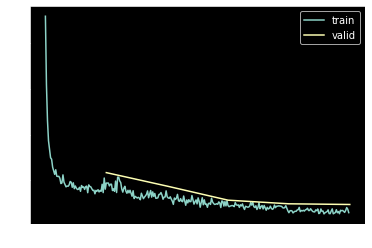

In [ ]:
learn.fit(epochs)

## Skip Connections 

The ResNet (_residual network_) was introduced in 2015 by Kaiming He et al in the article ["Deep Residual Learning for Image Recognition"](https://arxiv.org/abs/1512.03385). The key idea is using a skip connection to allow deeper networks to train successfully.

![""](https://raw.githubusercontent.com/Iamalos/course22p2/df9323235bc395b5c2f58a3d08b83761947b9b93/nbs/images/att_00042.png)

50 layer NN is a superset of a 20 layer NN so it should be at least as good. But in practice it is often not - it is worse. That means there is some problem during training of a net.

The basic idea is `out = conv2(conv1(in)) + in`. But this only works if we can add those together. In `conv2` and `conv1` has the same number of filters as `in` and they have stride 1. That shapes will be the same and we can add them together. If not, than we need to add a conv on `in` just to make `in` addable with conv layers. We call it `identity conv`.

Below we first create a _conv_block for `conv2(conv1(in))`. Conv1 has a stride of one and is used to adjust number of channels without changing height and width.

In [ ]:
#| export 
# conv_block if conv2(conv1(in)). for conv2 don't use activation
def _conv_block(ni, nf, stride, act=act_gr, norm=None, ks=3):
    # if norm: init.constant_(conv2[1].weight, 0.)
    return nn.Sequential(conv(ni, nf, stride=1, act=act, norm=norm, ks=ks),
                         conv(nf, nf, stride=stride, act=None, norm=norm, ks=ks))

class ResBlock(nn.Module):
    def __init__(self, ni, nf, stride=1, ks=3, act=act_gr, norm=None):
        super().__init__()
        # create conv2(conv1(in))
        self.convs = _conv_block(ni, nf, stride, act, norm, ks)
        # create idconvolution if ni and nf filters are not equal. 
        # Use minimum efforts (ks and stride are 1)
        self.idconv = fc.noop if ni==nf else conv(ni, nf, ks=1, stride=1, act=None)
        # if stride is not 1 (but 2) use Average pool
        self.pool = fc.noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)
        # apply activation
        self.act = act()
    
    def forward(self, x): return self.act(self.convs(x) + self.idconv(self.pool(x)))  

Jeremy discovered that initializing the `conv2` batchnorm weights to zero makes things worse in every model they tried, so they removed that. That init method was originally introduced to handle training extremely deep models (much deeper than we use here) -- it appears from this little test that it might be worse for less deep models

In [ ]:
def get_model(act=nn.ReLU, nfs=(8,16,32,64,128,256), norm=nn.BatchNorm2d):
    # first layer with stride 1 to keep width and height
    layers = [ResBlock(1, 8, stride=1, act=act, norm=norm)]
    # all intermediate layers
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [nn.Flatten(), nn.Linear(nfs[-1], 10, bias=False), nn.BatchNorm1d(10)]
    # put layers together into Sequential and move to device
    return nn.Sequential(*layers).to(def_device)

ask GPT about the difference in BN1d and BN2d

In [ ]:
# inp is (x,y) tuple
def _print_shape(hook, mod, inp, outp): print(type(mod).__name__, inp[0].shape, outp.shape)
model = get_model()
learn = TrainLearner(model, dls, F.cross_entropy, cbs=[DeviceCB(), SingleBatchCB()])
with Hooks(model, _print_shape) as hooks: learn.fit(1, train=False)

ResBlock torch.Size([2048, 1, 28, 28]) torch.Size([2048, 8, 28, 28])
ResBlock torch.Size([2048, 8, 28, 28]) torch.Size([2048, 16, 14, 14])
ResBlock torch.Size([2048, 16, 14, 14]) torch.Size([2048, 32, 7, 7])
ResBlock torch.Size([2048, 32, 7, 7]) torch.Size([2048, 64, 4, 4])
ResBlock torch.Size([2048, 64, 4, 4]) torch.Size([2048, 128, 2, 2])
ResBlock torch.Size([2048, 128, 2, 2]) torch.Size([2048, 256, 1, 1])
Flatten torch.Size([2048, 256, 1, 1]) torch.Size([2048, 256])
Linear torch.Size([2048, 256]) torch.Size([2048, 10])
BatchNorm1d torch.Size([2048, 10]) torch.Size([2048, 10])


We can improve the vizualization and use HTML to show a nice table.

The `nonlocal` keyword is used to work with variables inside nested functions, where the variable should not belong to the inner function.

In [ ]:
@fc.patch
def summary(self:Learner):
    res = '|Module|Input|Output|Num params|\n|--|--|--|--|\n'
    tot = 0
   
    def _f(hook, mod, inp, outp):
        nonlocal res, tot
        nparams = sum(o.numel() for o in mod.parameters())
        tot += nparams
        res += f'|{type(mod).__name__}|{tuple(inp[0].shape)}|{tuple(outp.shape)}|{nparams}|\n'
   
    with Hooks(self.model, _f) as hooks: self.fit(1, lr=1, train=False, cbs=SingleBatchCB())
    print("Tot params: ", tot)
    if fc.IN_NOTEBOOK:
        from IPython.display import Markdown
        return Markdown(res)
    else: print(res)

In [ ]:
TrainLearner(get_model(), dls, F.cross_entropy, cbs=DeviceCB()).summary()

Tot params:  1228908


|Module|Input|Output|Num params|
|--|--|--|--|
|ResBlock|(2048, 1, 28, 28)|(2048, 8, 28, 28)|712|
|ResBlock|(2048, 8, 28, 28)|(2048, 16, 14, 14)|3696|
|ResBlock|(2048, 16, 14, 14)|(2048, 32, 7, 7)|14560|
|ResBlock|(2048, 32, 7, 7)|(2048, 64, 4, 4)|57792|
|ResBlock|(2048, 64, 4, 4)|(2048, 128, 2, 2)|230272|
|ResBlock|(2048, 128, 2, 2)|(2048, 256, 1, 1)|919296|
|Flatten|(2048, 256, 1, 1)|(2048, 256)|0|
|Linear|(2048, 256)|(2048, 10)|2560|
|BatchNorm1d|(2048, 10)|(2048, 10)|20|


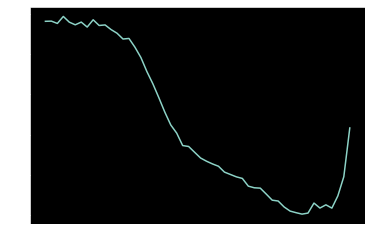

In [ ]:
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
MomentumLearner(model, dls, F.cross_entropy, cbs=DeviceCB()).lr_find()

In [ ]:
lr = 2e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

accuracy,loss,epoch,train
0.812,0.714,0,train
0.856,0.482,0,eval
0.893,0.351,1,train
0.765,0.658,1,eval
0.915,0.254,2,train
0.912,0.264,2,eval
0.936,0.192,3,train
0.922,0.224,3,eval
0.952,0.147,4,train
0.931,0.207,4,eval


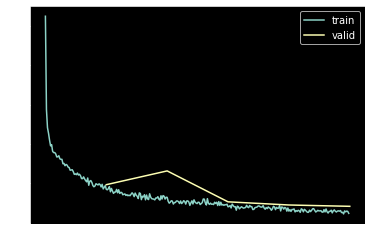

In [ ]:
learn.fit(epochs)

In [ ]:
import timm
from timm.models.resnet import BasicBlock, ResNet, Bottleneck

In [ ]:
' '.join(timm.list_models('*resnet*'))

'cspresnet50 cspresnet50d cspresnet50w eca_resnet33ts ecaresnet26t ecaresnet50d ecaresnet50d_pruned ecaresnet50t ecaresnet101d ecaresnet101d_pruned ecaresnet200d ecaresnet269d ecaresnetlight gcresnet33ts gcresnet50t inception_resnet_v2 lambda_resnet26rpt_256 lambda_resnet26t lambda_resnet50ts legacy_seresnet18 legacy_seresnet34 legacy_seresnet50 legacy_seresnet101 legacy_seresnet152 nf_ecaresnet26 nf_ecaresnet50 nf_ecaresnet101 nf_resnet26 nf_resnet50 nf_resnet101 nf_seresnet26 nf_seresnet50 nf_seresnet101 resnet10t resnet14t resnet18 resnet18d resnet26 resnet26d resnet26t resnet32ts resnet33ts resnet34 resnet34d resnet50 resnet50_gn resnet50c resnet50d resnet50s resnet50t resnet51q resnet61q resnet101 resnet101c resnet101d resnet101s resnet152 resnet152c resnet152d resnet152s resnet200 resnet200d resnetaa34d resnetaa50 resnetaa50d resnetaa101d resnetblur18 resnetblur50 resnetblur50d resnetblur101d resnetrs50 resnetrs101 resnetrs152 resnetrs200 resnetrs270 resnetrs350 resnetrs420 resne

In [ ]:
model = timm.create_model('resnet18d', in_chans=1, num_classes=10)
# model = ResNet(in_chans=1, block=BasicBlock, layers=[2,2,2,2], stem_width=32, avg_down=True)     

In [ ]:
lr = 2e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

accuracy,loss,epoch,train
0.777,0.643,0,train
0.778,0.873,0,eval
0.874,0.335,1,train
0.854,0.388,1,eval
0.907,0.247,2,train
0.887,0.303,2,eval
0.928,0.193,3,train
0.915,0.240,3,eval
0.946,0.145,4,train
0.922,0.222,4,eval


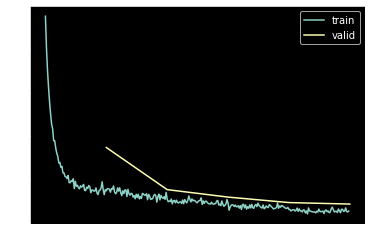

In [ ]:
learn.fit(epochs)

## Export  -

In [ ]:
import nbdev; nbdev.nbdev_export()

/root/.local/lib/python3.9/site-packages/nbdev/export.py:54: UserWarning: Notebook '/notebooks/fastai-p2/nbs/13_resnet.ipynb' uses `#|export` without `#|default_exp` cell.
Note nbdev2 no longer supports nbdev1 syntax. Run `nbdev_migrate` to upgrade.
See https://nbdev.fast.ai/getting_started.html for more information.
  warn(f"Notebook '{nbname}' uses `#|export` without `#|default_exp` cell.\n"
